# Structured Outputs for Multi-Agent Systems

In this cookbook, we will explore how to use Structured Outputs to build multi-agent systems.

Structured Outputs is a new capability that builds upon JSON mode and function calling to enforce a strict schema in a model output.

By using the new parameter `strict: true`, we are able to guarantee the response abides by a provided schema.

To demonstrate the power of this feature, we will use it to build a multi-agent system.

### Why build a Multi-Agent System?

When using function calling, if the number of functions (or tools) increases, the performance may suffer.

To mitigate this, we can logically group the tools together and have specialized "agents" that are able to solve specific tasks or sub-tasks, which will increase the overall system performance.

## Environment set up

In [52]:
from openai import OpenAI
from IPython.display import Image
import json
import pandas as pd
import matplotlib.pyplot as plt
from io import StringIO
import numpy as np
client = OpenAI()

In [53]:
MODEL = "gpt-4o-2024-08-06"

## Agents set up

The use case we will tackle is a data analysis task.

Let's first set up our 4-agents system:

1.   **Triaging agent:** Decides which agent(s) to call
2.   **Data pre-processing Agent:** Prepares data for analysis - for example by cleaning it up
3.   **Data Analysis Agent:** Performs analysis on the data
4.   **Data Visualization Agent:** Visualizes the output of the analysis to extract insights

We will start by defining the system prompts for each of these agents.

In [54]:
triaging_system_prompt = """You are a Triaging Agent. Your role is to assess the user's query and route it to the relevant agents. The agents available are:
- Data Processing Agent: Cleans, transforms, and aggregates data.
- Analysis Agent: Performs statistical, correlation, and regression analysis.
- Visualization Agent: Creates bar charts, line charts, and pie charts.

Use the send_query_to_agents tool to forward the user's query to the relevant agents. Also, use the speak_to_user tool to get more information from the user if needed."""

processing_system_prompt = """You are a Data Processing Agent. Your role is to clean, transform, and aggregate data using the following tools:
- clean_data
- transform_data
- aggregate_data"""

analysis_system_prompt = """You are an Analysis Agent. Your role is to perform statistical, correlation, and regression analysis using the following tools:
- stat_analysis
- correlation_analysis
- regression_analysis"""

visualization_system_prompt = """You are a Visualization Agent. Your role is to create bar charts, line charts, and pie charts using the following tools:
- create_bar_chart
- create_line_chart
- create_pie_chart"""

We will then define the tools for each agent.

Apart from the triaging agent, each agent will be equipped with tools specific to their role:

#### Data pre-processing agent


1.   Clean data
2.   Transform data
3.   Aggregate data

#### Data analysis agent

1.   Statistical analysis
2.   Correlation analysis
3.   Regression Analysis

#### Data visualization agent

1.   Create bar chart
2.   Create line chart
3.   Create pie chart

In [55]:
triage_tools = [
    {
        "type": "function",
        "function": {
            "name": "send_query_to_agents",
            "description": "Sends the user query to relevant agents based on their capabilities.",
            "parameters": {
                "type": "object",
                "properties": {
                    "agents": {
                        "type": "array",
                        "items": {"type": "string"},
                        "description": "An array of agent names to send the query to."
                    },
                    "query": {
                        "type": "string",
                        "description": "The user query to send."
                    }
                },
                "required": ["agents", "query"]
            }
        },
        "strict": True
    }
]

preprocess_tools = [
    {
        "type": "function",
        "function": {
            "name": "clean_data",
            "description": "Cleans the provided data by removing duplicates and handling missing values.",
            "parameters": {
                "type": "object",
                "properties": {
                    "data": {
                        "type": "string",
                        "description": "The dataset to clean. Should be in a suitable format such as JSON or CSV."
                    }
                },
                "required": ["data"],
                "additionalProperties": False
            }
        },
        "strict": True
    },
    {
        "type": "function",
        "function": {
            "name": "transform_data",
            "description": "Transforms data based on specified rules.",
            "parameters": {
                "type": "object",
                "properties": {
                    "data": {
                        "type": "string",
                        "description": "The data to transform. Should be in a suitable format such as JSON or CSV."
                    },
                    "rules": {
                        "type": "string",
                        "description": "Transformation rules to apply, specified in a structured format."
                    }
                },
                "required": ["data", "rules"],
                "additionalProperties": False
            }
        },
        "strict": True

    },
    {
        "type": "function",
        "function": {
            "name": "aggregate_data",
            "description": "Aggregates data by specified columns and operations.",
            "parameters": {
                "type": "object",
                "properties": {
                    "data": {
                        "type": "string",
                        "description": "The data to aggregate. Should be in a suitable format such as JSON or CSV."
                    },
                    "group_by": {
                        "type": "array",
                        "items": {"type": "string"},
                        "description": "Columns to group by."
                    },
                    "operations": {
                        "type": "string",
                        "description": "Aggregation operations to perform, specified in a structured format."
                    }
                },
                "required": ["data", "group_by", "operations"],
                "additionalProperties": False
            }
        },
        "strict": True
    }
]


analysis_tools = [
    {
        "type": "function",
        "function": {
            "name": "stat_analysis",
            "description": "Performs statistical analysis on the given dataset.",
            "parameters": {
                "type": "object",
                "properties": {
                    "data": {
                        "type": "string",
                        "description": "The dataset to analyze. Should be in a suitable format such as JSON or CSV."
                    }
                },
                "required": ["data"],
                "additionalProperties": False
            }
        },
        "strict": True
    },
    {
        "type": "function",
        "function": {
            "name": "correlation_analysis",
            "description": "Calculates correlation coefficients between variables in the dataset.",
            "parameters": {
                "type": "object",
                "properties": {
                    "data": {
                        "type": "string",
                        "description": "The dataset to analyze. Should be in a suitable format such as JSON or CSV."
                    },
                    "variables": {
                        "type": "array",
                        "items": {"type": "string"},
                        "description": "List of variables to calculate correlations for."
                    }
                },
                "required": ["data", "variables"],
                "additionalProperties": False
            }
        },
        "strict": True
    },
    {
        "type": "function",
        "function": {
            "name": "regression_analysis",
            "description": "Performs regression analysis on the dataset.",
            "parameters": {
                "type": "object",
                "properties": {
                    "data": {
                        "type": "string",
                        "description": "The dataset to analyze. Should be in a suitable format such as JSON or CSV."
                    },
                    "dependent_var": {
                        "type": "string",
                        "description": "The dependent variable for regression."
                    },
                    "independent_vars": {
                        "type": "array",
                        "items": {"type": "string"},
                        "description": "List of independent variables."
                    }
                },
                "required": ["data", "dependent_var", "independent_vars"],
                "additionalProperties": False
            }
        },
        "strict": True
    }
]

visualization_tools = [
    {
        "type": "function",
        "function": {
            "name": "create_bar_chart",
            "description": "Creates a bar chart from the provided data.",
            "parameters": {
                "type": "object",
                "properties": {
                    "data": {
                        "type": "string",
                        "description": "The data for the bar chart. Should be in a suitable format such as JSON or CSV."
                    },
                    "x": {
                        "type": "string",
                        "description": "Column for the x-axis."
                    },
                    "y": {
                        "type": "string",
                        "description": "Column for the y-axis."
                    }
                },
                "required": ["data", "x", "y"],
                "additionalProperties": False
            }
        },
        "strict": True
    },
    {
        "type": "function",
        "function": {
            "name": "create_line_chart",
            "description": "Creates a line chart from the provided data.",
            "parameters": {
                "type": "object",
                "properties": {
                    "data": {
                        "type": "string",
                        "description": "The data for the line chart. Should be in a suitable format such as JSON or CSV."
                    },
                    "x": {
                        "type": "string",
                        "description": "Column for the x-axis."
                    },
                    "y": {
                        "type": "string",
                        "description": "Column for the y-axis."
                    }
                },
                "required": ["data", "x", "y"],
                "additionalProperties": False
            }
        },
        "strict": True
    },
    {
        "type": "function",
        "function": {
            "name": "create_pie_chart",
            "description": "Creates a pie chart from the provided data.",
            "parameters": {
                "type": "object",
                "properties": {
                    "data": {
                        "type": "string",
                        "description": "The data for the pie chart. Should be in a suitable format such as JSON or CSV."
                    },
                    "labels": {
                        "type": "string",
                        "description": "Column for the labels."
                    },
                    "values": {
                        "type": "string",
                        "description": "Column for the values."
                    }
                },
                "required": ["data", "labels", "values"],
                "additionalProperties": False
            }
        },
        "strict": True
    }
]

## Tool execution

We need to write the code logic to:
- handle passing the user query to the multi-agent system
- handle the internal workings of the multi-agent system
- execute the tool calls

For the sake of brevity, we will only define the logic for tools that are relevant to the user query.

In [56]:
# Example query

user_query = """
Below is some data. I want you to first remove the duplicates then analyze the statistics of the data as well as plot a line chart.

house_size (m3), house_price ($)
90, 100
80, 90
100, 120
90, 100
"""


From the user query, we can infer that the tools we would need to call are `clean_data`, `start_analysis` and `use_line_chart`.

We will first define the execution function which runs tool calls.

This maps a tool call to the corresponding function. It then appends the output of the function to the conversation history.

In [57]:
def clean_data(data):
    data_io = StringIO(data)
    df = pd.read_csv(data_io, sep=",")
    df_deduplicated = df.drop_duplicates()
    return df_deduplicated

def stat_analysis(data):
    data_io = StringIO(data)
    df = pd.read_csv(data_io, sep=",")
    return df.describe()

def plot_line_chart(data):
    data_io = StringIO(data)
    df = pd.read_csv(data_io, sep=",")
    
    x = df.iloc[:, 0]
    y = df.iloc[:, 1]
    
    coefficients = np.polyfit(x, y, 1)
    polynomial = np.poly1d(coefficients)
    y_fit = polynomial(x)
    
    plt.figure(figsize=(10, 6))
    plt.plot(x, y, 'o', label='Data Points')
    plt.plot(x, y_fit, '-', label='Best Fit Line')
    plt.title('Line Chart with Best Fit Line')
    plt.xlabel(df.columns[0])
    plt.ylabel(df.columns[1])
    plt.legend()
    plt.grid(True)
    plt.show()

# Define the function to execute the tools
def execute_tool(tool_calls, messages):
    for tool_call in tool_calls:
        tool_name = tool_call.function.name
        tool_arguments = json.loads(tool_call.function.arguments)

        if tool_name == 'clean_data':
            # Simulate data cleaning
            cleaned_df = clean_data(tool_arguments['data'])
            cleaned_data = {"cleaned_data": cleaned_df.to_dict()}
            messages.append({"role": "tool", "name": tool_name, "content": json.dumps(cleaned_data)})
            print('Cleaned data: ', cleaned_df)
        elif tool_name == 'transform_data':
            # Simulate data transformation
            transformed_data = {"transformed_data": "sample_transformed_data"}
            messages.append({"role": "tool", "name": tool_name, "content": json.dumps(transformed_data)})
        elif tool_name == 'aggregate_data':
            # Simulate data aggregation
            aggregated_data = {"aggregated_data": "sample_aggregated_data"}
            messages.append({"role": "tool", "name": tool_name, "content": json.dumps(aggregated_data)})
        elif tool_name == 'stat_analysis':
            # Simulate statistical analysis
            stats_df = stat_analysis(tool_arguments['data'])
            stats = {"stats": stats_df.to_dict()}
            messages.append({"role": "tool", "name": tool_name, "content": json.dumps(stats)})
            print('Statistical Analysis: ', stats_df)
        elif tool_name == 'correlation_analysis':
            # Simulate correlation analysis
            correlations = {"correlations": "sample_correlations"}
            messages.append({"role": "tool", "name": tool_name, "content": json.dumps(correlations)})
        elif tool_name == 'regression_analysis':
            # Simulate regression analysis
            regression_results = {"regression_results": "sample_regression_results"}
            messages.append({"role": "tool", "name": tool_name, "content": json.dumps(regression_results)})
        elif tool_name == 'create_bar_chart':
            # Simulate bar chart creation
            bar_chart = {"bar_chart": "sample_bar_chart"}
            messages.append({"role": "tool", "name": tool_name, "content": json.dumps(bar_chart)})
        elif tool_name == 'create_line_chart':
            # Simulate line chart creation
            line_chart = {"line_chart": "sample_line_chart"}
            messages.append({"role": "tool", "name": tool_name, "content": json.dumps(line_chart)})
            plot_line_chart(tool_arguments['data'])
        elif tool_name == 'create_pie_chart':
            # Simulate pie chart creation
            pie_chart = {"pie_chart": "sample_pie_chart"}
            messages.append({"role": "tool", "name": tool_name, "content": json.dumps(pie_chart)})
    return messages

Next, we will create the tool handlers for each of the sub-agents.

These have a unique prompt and tool set passed to the model. 

The output is then passed to an execution function which runs the tool calls.

We will also append the messages to the conversation history.

In [58]:
# Define the functions to handle each agent's processing
def handle_data_processing_agent(query, conversation_messages):
    messages = [{"role": "system", "content": processing_system_prompt}]
    messages.append({"role": "user", "content": query})

    response = client.chat.completions.create(
        model=MODEL,
        messages=messages,
        temperature=0,
        tools=preprocess_tools,
    )

    conversation_messages.append([tool_call.function for tool_call in response.choices[0].message.tool_calls])
    execute_tool(response.choices[0].message.tool_calls, conversation_messages)

def handle_analysis_agent(query, conversation_messages):
    messages = [{"role": "system", "content": analysis_system_prompt}]
    messages.append({"role": "user", "content": query})

    response = client.chat.completions.create(
        model=MODEL,
        messages=messages,
        temperature=0,
        tools=analysis_tools,
    )

    conversation_messages.append([tool_call.function for tool_call in response.choices[0].message.tool_calls])
    execute_tool(response.choices[0].message.tool_calls, conversation_messages)

def handle_visualization_agent(query, conversation_messages):
    messages = [{"role": "system", "content": visualization_system_prompt}]
    messages.append({"role": "user", "content": query})

    response = client.chat.completions.create(
        model=MODEL,
        messages=messages,
        temperature=0,
        tools=visualization_tools,
    )

    conversation_messages.append([tool_call.function for tool_call in response.choices[0].message.tool_calls])
    execute_tool(response.choices[0].message.tool_calls, conversation_messages)


Finally, we create the overarching tool to handle processing the user query.

This function takes the user query, gets a response from the model and handles passing it to the other agents to execute. In addition to this, we will keep the state of the ongoing conversation.

In [59]:
# Function to handle user input and triaging
def handle_user_message(user_query, conversation_messages=[]):
    user_message = {"role": "user", "content": user_query}
    conversation_messages.append(user_message)


    messages = [{"role": "system", "content": triaging_system_prompt}]
    messages.extend(conversation_messages)

    response = client.chat.completions.create(
        model=MODEL,
        messages=messages,
        temperature=0,
        tools=triage_tools,
    )

    conversation_messages.append([tool_call.function for tool_call in response.choices[0].message.tool_calls])

    for tool_call in response.choices[0].message.tool_calls:
        if tool_call.function.name == 'send_query_to_agents':
            agents = json.loads(tool_call.function.arguments)['agents']
            query = json.loads(tool_call.function.arguments)['query']
            for agent in agents:
                if agent == "Data Processing Agent":
                    handle_data_processing_agent(query, conversation_messages)
                elif agent == "Analysis Agent":
                    handle_analysis_agent(query, conversation_messages)
                elif agent == "Visualization Agent":
                    handle_visualization_agent(query, conversation_messages)

    return conversation_messages

## Multi-agent system execution

Finally, we run the overarching `handle_user_message` function on the user query and view the output.

Cleaned data:     house_size (m3)   house_price ($)
0               90               100
1               80                90
2              100               120
Statistical Analysis:         house_size  house_price
count    4.000000     4.000000
mean    90.000000   102.500000
std      8.164966    12.583057
min     80.000000    90.000000
25%     87.500000    97.500000
50%     90.000000   100.000000
75%     92.500000   105.000000
max    100.000000   120.000000


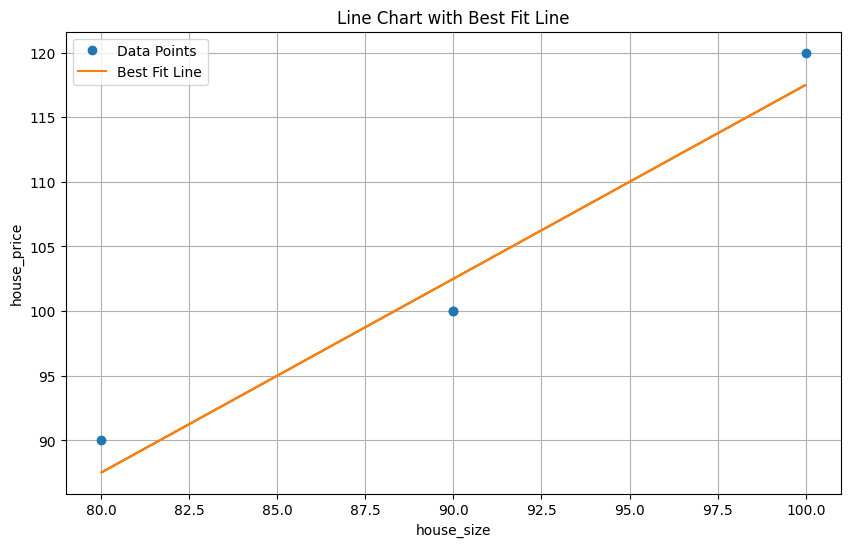

[{'role': 'user',
  'content': '\nBelow is some data. I want you to first remove the duplicates then analyze the statistics of the data as well as plot a line chart.\n\nhouse_size (m3), house_price ($)\n90, 100\n80, 90\n100, 120\n90, 100\n'},
 [Function(arguments='{"agents": ["Data Processing Agent"], "query": "Remove duplicates from the data: house_size (m3), house_price ($)\\n90, 100\\n80, 90\\n100, 120\\n90, 100"}', name='send_query_to_agents'),
  Function(arguments='{"agents": ["Analysis Agent"], "query": "Analyze the statistics of the data: house_size (m3), house_price ($)\\n90, 100\\n80, 90\\n100, 120\\n90, 100"}', name='send_query_to_agents'),
  Function(arguments='{"agents": ["Visualization Agent"], "query": "Plot a line chart for the data: house_size (m3), house_price ($)\\n90, 100\\n80, 90\\n100, 120\\n90, 100"}', name='send_query_to_agents')],
 [Function(arguments='{"data":"house_size (m3), house_price ($)\\n90, 100\\n80, 90\\n100, 120\\n90, 100"}', name='clean_data')],
 {'r

In [60]:
handle_user_message(user_query)

## Conclusion

In this cookbook, we've explored how to leverage Structured Outputs to build more robust multi-agent systems.

Using this new feature allows to make sure that tool calls follow the specified schema and avoids having to handle edge cases or validate arguments on your side.

This can be applied to many more use cases, and we hope you can take inspiration from this to build your own use case!